In [1]:
# Upload file kaggle.json
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Mengambil dataset kaggle 
! kaggle datasets download guy007/nutrientdeficiencysymptomsinrice

 98% 971M/989M [00:10<00:00, 173MB/s]
100% 989M/989M [00:11<00:00, 94.2MB/s]


In [ ]:
! unzip nutrientdeficiencysymptomsinrice.zip

In [33]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [11]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import splitfolders

In [15]:
splitfolders.ratio("/content/rice_plant_lacks_nutrients/", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 1156 files [00:03, 344.78 files/s]


In [16]:
# Folder location
data_dir = pathlib.Path('/content/output/train')
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

In [17]:
# Show classes
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['Nitrogen(N)' 'Phosphorus(P)' 'Potassium(K)']


In [18]:
# Show total data in folder
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
3 folder and 0 images in output/test
0 folder and 20 images in output/test/Potassium(K)
0 folder and 22 images in output/test/Nitrogen(N)
0 folder and 18 images in output/test/Phosphorus(P)
3 folder and 0 images in output/val
0 folder and 76 images in output/val/Potassium(K)
0 folder and 88 images in output/val/Nitrogen(N)
0 folder and 66 images in output/val/Phosphorus(P)
3 folder and 0 images in output/train
0 folder and 287 images in output/train/Potassium(K)
0 folder and 330 images in output/train/Nitrogen(N)
0 folder and 249 images in output/train/Phosphorus(P)


In [19]:
# Function for showing image sources
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (322, 4026, 3)


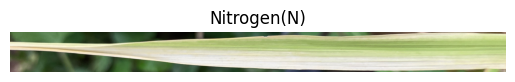

Image Shape : (3871, 309, 3)


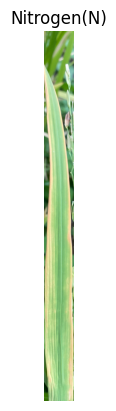

In [21]:
# Show image for classes 'Nitrogen(N)'
for i in range(1,3):
    img_n = view_random_image(target_dir='output/train/', target_class='Nitrogen(N)')

Image Shape : (3232, 263, 3)


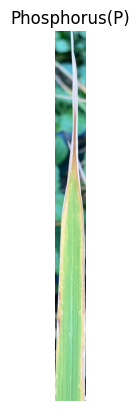

Image Shape : (3998, 406, 3)


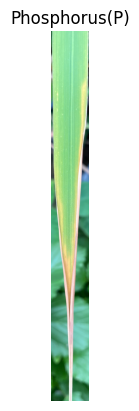

In [22]:
# Show image for classes 'Phosphorus(P)'
for i in range(1,3):
    img_n = view_random_image(target_dir='output/train/', target_class='Phosphorus(P)')

In [23]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [24]:
# flow from directory using datagen (Pipeline)
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 866 images belonging to 3 classes.
Found 230 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [25]:
# Check class_indices
train_data.class_indices

{'Nitrogen(N)': 0, 'Phosphorus(P)': 1, 'Potassium(K)': 2}

In [26]:
# Set labels
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [27]:
# Check shapes of labels
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (866,)
val_y.shape:  (230,)
test_y.shape:  (60,)


In [34]:
# Create checkpoint callback
checkpoint_path = "nutrient_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [35]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [28]:
# Model Definition
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [30]:
# Model Preparation
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [31]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [36]:
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 7,333,187 total parameters in this model.
There are 295,683 trainable parameters in this model.


In [37]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 6


In [32]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                             

In [38]:
# train model
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data),
    epochs=30,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/30
55/55 [==============================] - 155s 3s/step - loss: 0.9630 - accuracy: 0.5820 - val_loss: 0.4636 - val_accuracy: 0.8565
Epoch 2/30
55/55 [==============================] - 144s 3s/step - loss: 0.4661 - accuracy: 0.8002 - val_loss: 0.3296 - val_accuracy: 0.8826
Epoch 3/30
55/55 [==============================] - 138s 3s/step - loss: 0.3795 - accuracy: 0.8545 - val_loss: 0.3452 - val_accuracy: 0.8826
Epoch 4/30
55/55 [==============================] - 153s 3s/step - loss: 0.3626 - accuracy: 0.8568 - val_loss: 0.2679 - val_accuracy: 0.9043
Epoch 5/30
55/55 [==============================] - 131s 2s/step - loss: 0.3356 - accuracy: 0.8741 - val_loss: 0.3543 - val_accuracy: 0.8652
Epoch 6/30
55/55 [==============================] - 142s 3s/step - loss: 0.2766 - accuracy: 0.8822 - val_loss: 0.2420 - val_accuracy: 0.9217
Epoch 7/30
55/55 [==============================] - 142s 3s/step - loss: 0.3143 - accuracy: 0.8684 - val_loss: 0.2536 - val_accuracy: 0.9130
Epoch 8/30
55

In [46]:
model.save("leaf_nutrient.h5")

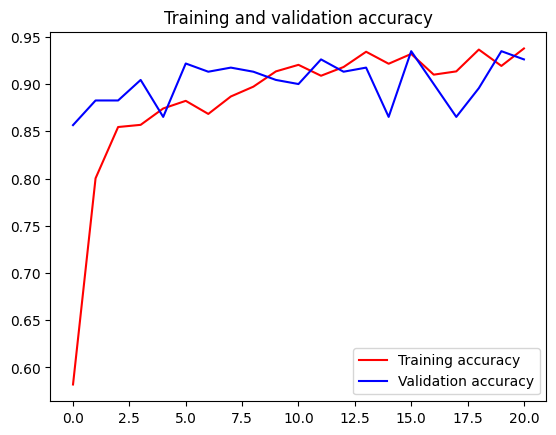

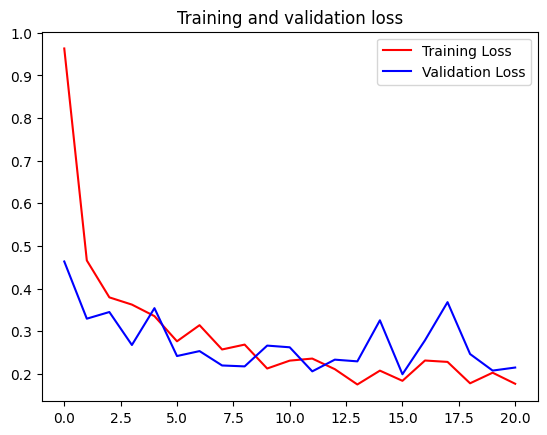

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  427


In [41]:
base_model.trainable = True
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                             

In [44]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 327


In [47]:
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/20
55/55 [==============================] - 310s 5s/step - loss: 0.1598 - accuracy: 0.9423 - val_loss: 0.2101 - val_accuracy: 0.9130
Epoch 2/20
55/55 [==============================] - 283s 5s/step - loss: 0.1189 - accuracy: 0.9596 - val_loss: 0.2807 - val_accuracy: 0.9000
Epoch 3/20
55/55 [==============================] - 284s 5s/step - loss: 0.1282 - accuracy: 0.9584 - val_loss: 0.1679 - val_accuracy: 0.9565
Epoch 4/20
55/55 [==============================] - 282s 5s/step - loss: 0.1325 - accuracy: 0.9503 - val_loss: 0.2563 - val_accuracy: 0.9174
Epoch 5/20
55/55 [==============================] - 281s 5s/step - loss: 0.0781 - accuracy: 0.9734 - val_loss: 0.2721 - val_accuracy: 0.9174
Epoch 6/20
55/55 [==============================] - 281s 5s/step - loss: 0.0735 - accuracy: 0.9734 - val_loss: 0.2192 - val_accuracy: 0.9304
Epoch 7/20
55/55 [==============================] - 263s 5s/step - loss: 0.0754 - accuracy: 0.9723 - val_loss: 0.3042 - val_accuracy: 0.9043
Epoch 8/20
55

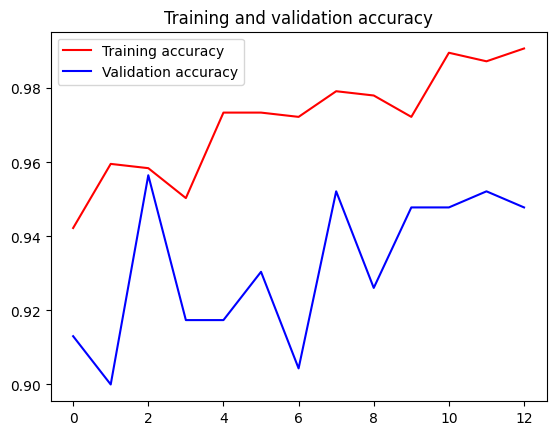

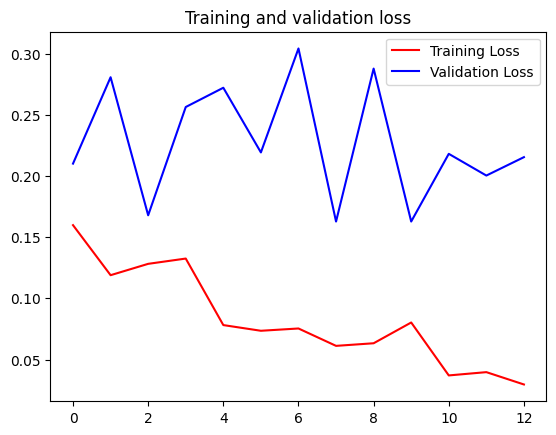

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
model.save("leaf_nutrient_tuned.h5")